In [1]:
import numpy as np

import matplotlib.pyplot as plt

from multiprocess import Pool
from functools import partial
import numpy as np

import games

import cpb
# import cpb_uniform
import cpb_gaussian

import random_algo

import plotly.graph_objects as go

import synthetic_data
import cpb_side
import cpb_side_gaussian


def evaluate_parallel(nbCores, n_folds, horizon, alg, game, type):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon, type)

    np.random.seed(1)
    distributions = []
    context_generators = []

    for jobid in range(n_folds):
        
        p = np.random.uniform(0, 0.2) if type == 'easy' else np.random.uniform(0.4,0.5)
        distributions.append( [p, 1-p] )

        d = 2
        margin =0.01
        contexts = synthetic_data.LinearContexts( np.array([0.5,0.5]), 0, d, margin) #synthetic_data.ToyContexts( )
        context_generators.append( contexts )

    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), zip(distributions , context_generators ,range(n_folds)) ) ) 

class Evaluation:

    def __init__(self, horizon,type ):
        self.type = type
        self.horizon = horizon
        # self.outcome_distribution = outcome_distribution

    def get_outcomes(self, game, job_id):
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()

        distribution, context_generator, jobid = job

        np.random.seed(jobid)

        # outcome_distribution =  {'spam':0.5,'ham':0.5}
        outcome_distribution =  {'spam':distribution[0],'ham':distribution[1]}

        game.set_outcome_distribution( outcome_distribution, jobid )
        #print('optimal action', game.i_star)

        # action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)
        contexts = [ context_generator.get_context(outcome) for outcome in outcomes ]
        # context_generator.generate_unique_context()
        # contexts = [ context_generator.get_same_context(outcome) for outcome in outcomes ]
        #print('theta', context_generator.w )

        cumRegret =  np.zeros(self.horizon, dtype =float)

        for t in range(self.horizon):

            # Environment chooses one outcome and one context associated to this outcome
            outcome = outcomes[t]
            context = contexts[t]

            # policy chooses one action
            # print('t', t,  'outcome', outcome, 'context', context)
            action = alg.get_action(t, context)

            # print('t', t, 'action', action, 'outcome', outcome, )
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )
            
            # print('nu', alg.nu / alg.n )
            regret = game.LossMatrix[action, outcome] - np.min( game.LossMatrix[...,outcome] )
            # print( 'regret:' , regret )
            cumRegret[t] =  regret
            # print()
        # regret = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter
        #context_regret = np.cumsum( cumRegret )

        return  np.cumsum( cumRegret ) #regret


Restricted license - for non-production use only - expires 2023-10-25


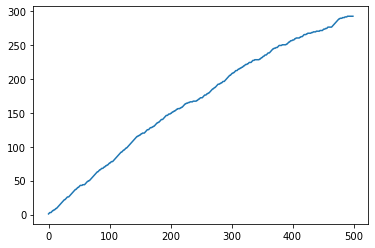

In [2]:
n_cores = 1
n_folds = 1
horizon = 500

game =  games.apple_tasting( False ) 

alg = cpb_side.CPB_side(  game, horizon, 1.01, 0.001)

task = Evaluation(horizon, 'easy')

outcome_distribution = [0.2, 0.8]
d = 2
margin = 0.01
contexts_generator = synthetic_data.LinearContexts( np.array([0.5,0.5]), 0, d, margin) #synthetic_data.ToyContexts( )
job = (outcome_distribution, contexts_generator, 9 )

result = task.eval_policy_once(alg,game, job)
#plt.plot(range(horizon), result)
# fig = go.Figure( )
# regret = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result,0) 
# xcoords = np.arange(0,horizon,1).tolist()

# fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='blue'), mode='lines',  name='TPSM' )) # 

plt.plot(result)

In [3]:
n_cores = 8
n_folds = 25
horizon = 2500

game = games.apple_tasting(False)

algos = [ random_algo.Random(  game, horizon, ),    
          cpb.CPB(  game, horizon, 1.01),  
          cpb_side.CPB_side(  game, horizon,1.01, 0.05), 
          cpb_side.CPB_side(  game, horizon,1.01, 0.001), 
          cpb_side_gaussian.RandCPB_side(game, horizon, 1.01, 0.05, 1/8, 10, False, 10e-7)   ] #cpb_side_gaussian.CPB_side_gauss(game, horizon, 1/16, 10)

colors = [  [0,0,0], [250,0,0], [0,250,0] , [0,0,250],  [200,0,200]  ] #, [250,0,0]
labels = [  'random',  'CBP', 'CBP-side 0.05',  'CPB-side 0.001', 'RandCBP-side' ] #  'Rand CPB-side'

fig = go.Figure(    )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
    np.save('./results/apple_tasting/easy_context_{}_{}_{}'.format(horizon,n_folds, label), result)
    regret =  np.mean(result,0) 
    
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=True )  )
    
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                 xaxis_title="Sequence",
                 yaxis_title="Regret",
                 margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ), 
                  font=dict(size=13,) )

fig.show(legend=True)

# fig.write_image("./easy_AT_context.pdf")

fig.update_xaxes(type="log")
# fig.write_image("./easy_AT_context_log.pdf")

fig.show()

weights [0. 1.]
nbCores: 8 nbFolds: 25 Horizon: 2500
nbCores: 8 nbFolds: 25 Horizon: 2500
nbCores: 8 nbFolds: 25 Horizon: 2500
nbCores: 8 nbFolds: 25 Horizon: 2500
nbCores: 8 nbFolds: 25 Horizon: 2500
